In [110]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [111]:
file_path = "Spotify+Streaming+History/spotify_history.csv" 
spotify_data = pd.read_csv(file_path)


In [112]:
spotify_data['ts'] = pd.to_datetime(spotify_data['ts'], errors='coerce')
spotify_data['year_month'] = spotify_data['ts'].dt.to_period('M')
spotify_data['week'] = spotify_data['ts'].dt.to_period('W-SUN')


In [113]:
spotify_data['minutes_played'] = spotify_data['ms_played'] / 60000


# Aggregating Total Listening Time by Month

In [114]:
monthly_listening_time = spotify_data.groupby('year_month')['minutes_played'].sum().reset_index()
monthly_listening_time.columns = ['ds', 'y']
monthly_listening_time['ds'] = monthly_listening_time['ds'].dt.to_timestamp()

In [115]:
monthly_listening_time

,ds,y
0,2013-07-01,228.495783
1,2013-08-01,138.957450
2,2013-09-01,102.354650
3,2014-01-01,62.363783
4,2015-01-01,33.152850
...,...,...
113,2024-08-01,2683.232367
114,2024-09-01,2785.358967
115,2024-10-01,3642.407400
116,2024-11-01,3232.413250


In [116]:
prophet = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=10)

prophet.fit(monthly_listening_time)

13:53:34 - cmdstanpy - INFO - Chain [1] start processing
13:53:34 - cmdstanpy - INFO - Chain [1] done processing


In [117]:
future = prophet.make_future_dataframe(periods=12, freq='M')
forecast = prophet.predict(future)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


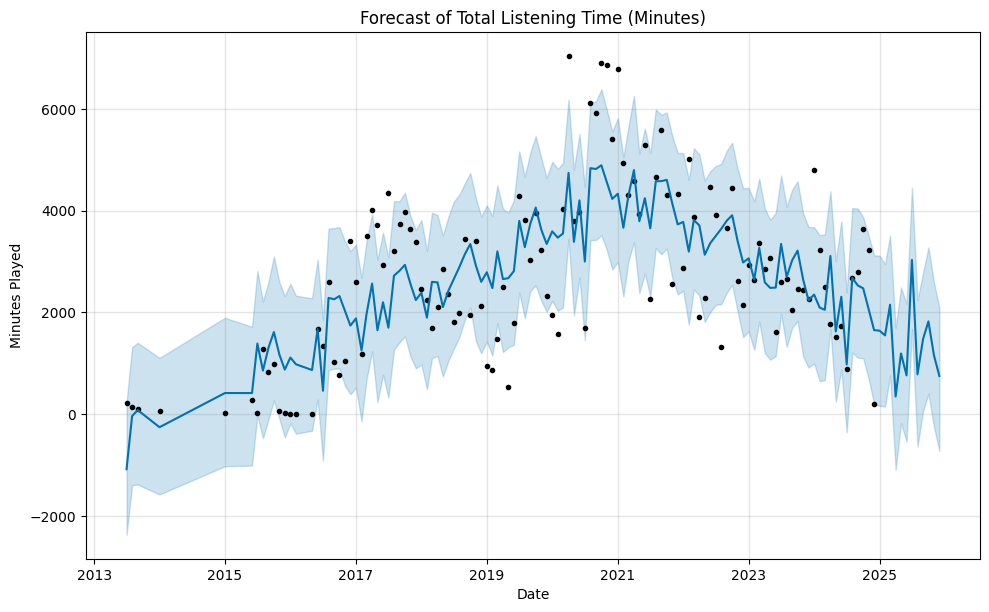

In [118]:
fig = prophet.plot(forecast)
plt.title("Forecast of Total Listening Time (Minutes)")
plt.xlabel("Date")
plt.ylabel("Minutes Played")
plt.show()

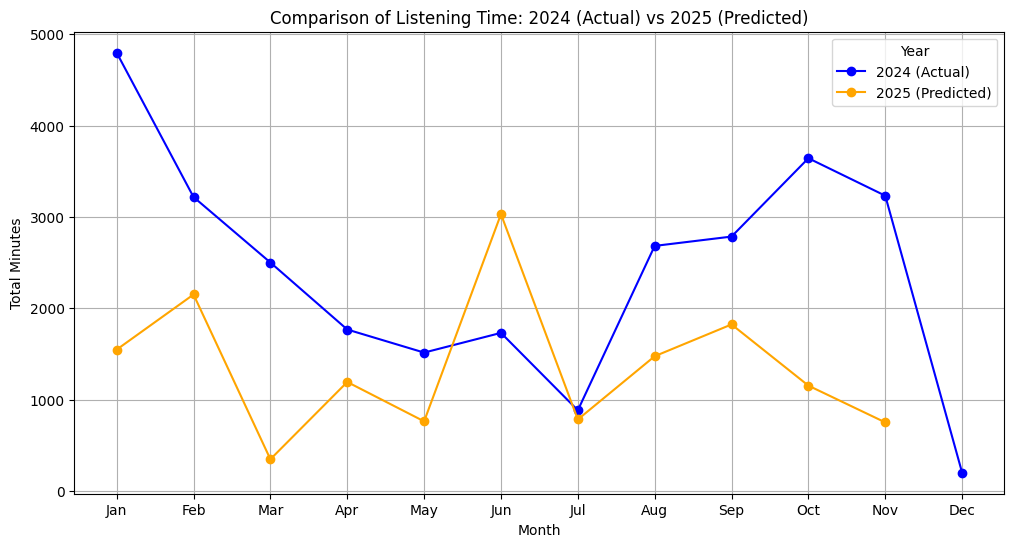

In [119]:

# Extract actual listening data for 2024
spotify_data['year'] = spotify_data['ts'].dt.year
spotify_data['month'] = spotify_data['ts'].dt.month
actual_2024 = spotify_data[spotify_data['year'] == 2024].groupby('month')['minutes_played'].sum()

# Filter forecast data for 2025
forecast_2025 = forecast[forecast['ds'].dt.year == 2025]

# Group and sum predicted values ('yhat') for each month in 2025
predicted_2025 = forecast_2025.groupby(forecast_2025['ds'].dt.month)['yhat'].sum()

# Plot the results as a line chart
plt.figure(figsize=(12, 6))

# Line for 2024 (actual values)
plt.plot(actual_2024.index, actual_2024.values, marker='o', label='2024 (Actual)', color='blue')

# Line for 2025 (predicted values)
plt.plot(predicted_2025.index, predicted_2025.values, marker='o', label='2025 (Predicted)', color='orange')

# Add chart details
plt.title('Comparison of Listening Time: 2024 (Actual) vs 2025 (Predicted)')
plt.xlabel('Month')
plt.ylabel('Total Minutes')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True)

# Show the chart
plt.show()


In [120]:
# Filter out December 2024 from the data
spotify_data['year'] = spotify_data['ts'].dt.year
spotify_data['month'] = spotify_data['ts'].dt.month
filtered_2024 = spotify_data[(spotify_data['year'] == 2024) & (spotify_data['month'] != 12)]

# Group by month and sum the minutes played for 2024 (excluding December)
actual_2024 = filtered_2024.groupby('month')['minutes_played'].sum()

# Filter forecast data for 2025
forecast_2025 = forecast[forecast['ds'].dt.year == 2025]

# Group and sum predicted values ('yhat') for each month in 2025
predicted_2025 = forecast_2025.groupby(forecast_2025['ds'].dt.month)['yhat'].sum()

# Combine actual and predicted data into a single DataFrame
comparison_df = pd.DataFrame({
    'Month': range(1, 12),  # Months 1 to 11
    'Actual_2024': actual_2024.values,
    'Predicted_2025': predicted_2025.values[:11]  # Exclude December for 2025 to match
})

# Display the resulting DataFrame
print(comparison_df)

# Optional: Save the DataFrame to a CSV file
comparison_df.to_csv("listening_minutes_comparison_2024_2025_no_december_1.csv", index=False)



    Month  Actual_2024  Predicted_2025
0       1  4796.927083     1548.573584
1       2  3217.964267     2151.622033
2       3  2501.536767      348.972818
3       4  1768.469550     1194.345810
4       5  1516.001500      763.738994
5       6  1731.748683     3030.816091
6       7   884.623067      784.142133
7       8  2683.232367     1476.296058
8       9  2785.358967     1824.090079
9      10  3642.407400     1154.422774
10     11  3232.413250      752.253232


Mean Absolute Error (MAE): 986.45
Root Mean Square Error (RMSE): 1353.25
Mean Absolute Percentage Error (MAPE): 153.52%


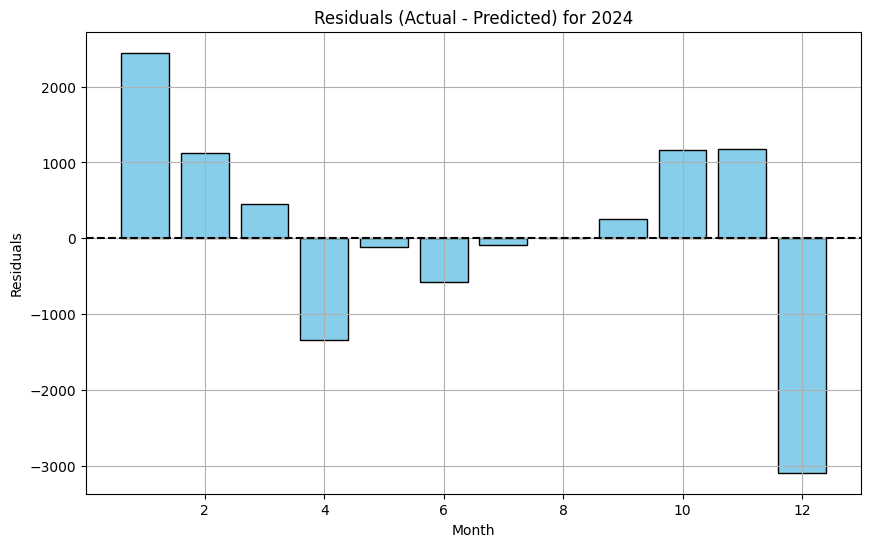

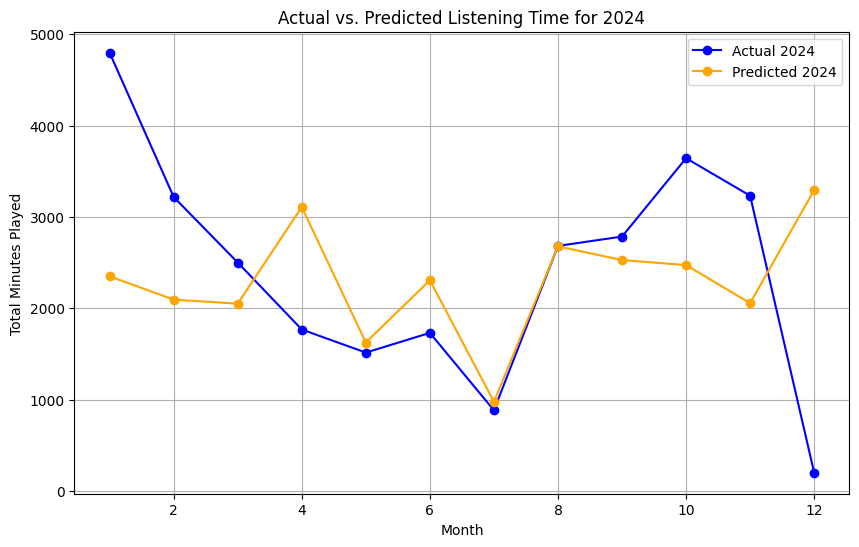

In [121]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Combine actual and predicted data for 2024 (for evaluation)
forecast_2024 = forecast[forecast['ds'].dt.year == 2024]
actual_2024 = spotify_data[(spotify_data['year'] == 2024)].groupby('month')['minutes_played'].sum()

# Ensure alignment of actuals and predictions
evaluation_df = pd.DataFrame({
    'Month': actual_2024.index,
    'Actual_2024': actual_2024.values,
    'Predicted_2024': forecast_2024.groupby(forecast_2024['ds'].dt.month)['yhat'].sum().values
})

# Calculate residuals
evaluation_df['Residuals'] = evaluation_df['Actual_2024'] - evaluation_df['Predicted_2024']

# Compute evaluation metrics
mae = mean_absolute_error(evaluation_df['Actual_2024'], evaluation_df['Predicted_2024'])
rmse = np.sqrt(mean_squared_error(evaluation_df['Actual_2024'], evaluation_df['Predicted_2024']))
mape = np.mean(np.abs((evaluation_df['Actual_2024'] - evaluation_df['Predicted_2024']) / evaluation_df['Actual_2024'])) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Save evaluation results
evaluation_df.to_csv("evaluation_results.csv", index=False)

# Plot residuals
plt.figure(figsize=(10, 6))
plt.bar(evaluation_df['Month'], evaluation_df['Residuals'], color='skyblue', edgecolor='black')
plt.axhline(0, linestyle='--', color='black')
plt.title("Residuals (Actual - Predicted) for 2024")
plt.xlabel("Month")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(evaluation_df['Month'], evaluation_df['Actual_2024'], label='Actual 2024', marker='o', color='blue')
plt.plot(evaluation_df['Month'], evaluation_df['Predicted_2024'], label='Predicted 2024', marker='o', color='orange')
plt.title("Actual vs. Predicted Listening Time for 2024")
plt.xlabel("Month")
plt.ylabel("Total Minutes Played")
plt.legend()
plt.grid(True)
plt.show()
